<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/SDUEBA_008_diabetes_tspg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
import numpy as np
print(np.__version__)

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
1.26.4


In [2]:
# Dependencies
import numpy as np
import scipy
import os
import re
import string
import pandas as pd
from collections import Counter
import sklearn
from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
!pip install gensim
from gensim.models import Word2Vec

In [4]:
!pip install subgroups
from google.colab import drive

In [5]:
!git clone https://github.com/uef-machine-learning/tspgclu.git
%cd tspgclu
!pip install -r requirements.txt
!pip install .
!python python/ex_cluster.pyimport tspg
import tspg

fatal: destination path 'tspgclu' already exists and is not an empty directory.
/content/tspgclu
Processing /content/tspgclu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tspg: filename=tspg-1.0-cp311-cp311-linux_x86_64.whl size=536184 sha256=097c651d029c0500415610244c61f963a978df7a308ec98b40d56caf9488fdd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-qz6gp610/wheels/76/b6/67/20b88094c0a7504d3e162a7729d9ab59dad6b547bc230d033f
Successfully built tspg
  Attempting uninstall: tspg
    Found existing installation: tspg 1.0
    Uninstalling tspg-1.0:
      Successfully uninstalled tspg-1.0
python3: can't open file '/content/tspgclu/python/ex_cluster.pyimport': [Errno 2] No such file or directory


In [17]:
#SDUEBA Parameters:
"""
vector_space_dimention  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
mixed_threashold        ... threshold for classifying a cluster as mixed
"""

vector_space_dimension = 36
n_clusters = 23
clustering_method = "tspg"      #"agglomerative"/"spherical_kmeans"/"tspg"
frac_of_dataset = 0.2

max_depth = 2
test_size = 0.2
mixed_threshold = 0.9
tree_accuracy_threshold = 0.95

#Quality metric parameters
description_length_limit = 2
difference_limit = 0
subgroup_size_limit = 10

In [19]:
#Data augemntation
def create_shorter_sample(df, frac=None):
    df_sampled = df.sample(frac=frac, random_state=73)
    df_sampled = df_sampled.reset_index(drop=True)
    return df_sampled
def get_binary_columns(df):
    binary_cols = []
    for col in df.columns:
        unique_values = df[col].unique()
        if len(unique_values) == 2:
            binary_cols.append(col)
    return binary_cols

drive.mount('/content/drive')
df = create_shorter_sample(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes_preprocessed.csv'), frac=frac_of_dataset)
features_raw = df[['race', 'gender', 'age', 'weight', 'admission_type_id',
                   'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
                   'num_lab_procedures', 'num_procedures', 'num_medications',
                   'number_outpatient', 'number_emergency', 'number_inpatient',
                   'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'insulin',
                   'change', 'diabetesMed', 'had_emergency', 'had_inpatient_days',
                   'had_outpatient_days', 'discharge_disposition', 'admission_source',
                   'admission_type']]
target_df = df[['readmit_binary']]
target_df['readmit_binary'] = target_df['readmit_binary'].replace({True: 'Yes', False: 'No', 'True': 'Yes', 'False': 'No'})


print(get_binary_columns(df))
print(features_raw.columns)
features_raw.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['tolbutamide', 'miglitol', 'tolazamide', 'glyburide-metformin', 'glipizide-metformin', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmit_30_days', 'readmit_binary', 'had_emergency', 'had_inpatient_days', 'had_outpatient_days']
Index(['race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'insulin', 'change', 'diabetesMed', 'had_emergency',
       'had_inpatient_days', 'had_outpatient_days', 'discharge_disposition',
       'admission_source', 'admission_type'],
      dtype='object')


<ipython-input-19-2384126e7af4>:15: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = create_shorter_sample(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/diabetes_preprocessed.csv'), frac=frac_of_dataset)
<ipython-input-19-2384126e7af4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['readmit_binary'] = target_df['readmit_binary'].replace({True: 'Yes', False: 'No', 'True': 'Yes', 'False': 'No'})


,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,metformin,insulin,change,diabetesMed,had_emergency,had_inpatient_days,had_outpatient_days,discharge_disposition,admission_source,admission_type
0,Caucasian,Female,[80-90),NaN,2,1,7,12,55,0,...,No,No,No,Yes,False,True,False,Discharged to home,Emergency Room,Urgent
1,Caucasian,Male,[60-70),NaN,2,3,7,6,53,3,...,No,No,No,No,False,False,False,Discharged/transferred to SNF,Emergency Room,Urgent
2,AfricanAmerican,Female,[50-60),NaN,5,6,17,6,17,5,...,Steady,Down,Ch,Yes,False,False,True,Discharged/transferred to home with home healt...,NaN,Not Available
3,AfricanAmerican,Female,[50-60),NaN,2,1,1,3,43,5,...,No,Steady,No,Yes,False,False,False,Discharged to home,Physician Referral,Urgent
4,Caucasian,Male,[50-60),NaN,2,3,7,3,75,0,...,No,Up,Ch,Yes,False,False,False,Discharged/transferred to SNF,Emergency Room,Urgent


In [20]:
# Data augmentation sentence creation
training_df = pd.merge(features_raw, target_df, left_index=True, right_index=True).astype(str)

for column in training_df.columns:
    split_columns = column.split("_")
    jointed_columns = ' '.join(split_columns)

    def transform_value(x):
        values = [f"{jointed_columns} is {val.strip()}" for val in x.split(',')]
        return ', '.join(values)

    training_df[column] = training_df[column].apply(transform_value)

sentences = training_df.apply(lambda row: list(row), axis=1).tolist()

for i in range(min(5, len(sentences))):
    print(sentences[i])


['race is Caucasian', 'gender is Female', 'age is [80-90)', 'weight is nan', 'admission type id is 2', 'discharge disposition id is 1', 'admission source id is 7', 'time in hospital is 12', 'num lab procedures is 55', 'num procedures is 0', 'num medications is 17', 'number outpatient is 0', 'number emergency is 0', 'number inpatient is 1', 'number diagnoses is 9', 'max glu serum is nan', 'A1Cresult is nan', 'metformin is No', 'insulin is No', 'change is No', 'diabetesMed is Yes', 'had emergency is False', 'had inpatient days is True', 'had outpatient days is False', 'discharge disposition is Discharged to home', 'admission source is Emergency Room', 'admission type is Urgent', 'readmit binary is Yes']
['race is Caucasian', 'gender is Male', 'age is [60-70)', 'weight is nan', 'admission type id is 2', 'discharge disposition id is 3', 'admission source id is 7', 'time in hospital is 6', 'num lab procedures is 53', 'num procedures is 3', 'num medications is 15', 'number outpatient is 0', 

In [21]:
#Word2Vec training and clustering
#https://journalofbigdata.springeropen.com/articles/10.1186/s40537-024-01053-x
class Word2VecModel:
    def __init__(self, sentences, vector_size, window=5, min_count=1):
        self.model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count)

    def get_embedding(self, sentence):
        word_embeddings = [self.model.wv[word] for word in sentence if word in self.model.wv]
        return np.mean(word_embeddings, axis=0) if word_embeddings else np.zeros(self.model.vector_size)

class SentenceEmbedder:
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model

    def generate_embeddings(self, sentences, normalize=False):
        embeddings = np.array([self.word2vec_model.get_embedding(sentence) for sentence in sentences])
        return embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True) if normalize else embeddings

class SphericalKMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None

    def fit(self, X):
        np.random.seed(self.random_state)
        X = normalize(X, norm='l2', axis=1)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.cluster_centers_ = X[indices]

        for _ in range(self.max_iter):
            similarities = X @ self.cluster_centers_.T
            labels = np.argmax(similarities, axis=1)
            new_centroids = np.array([
                normalize(X[labels == j].mean(axis=0).reshape(1, -1))
                if np.any(labels == j) else self.cluster_centers_[j]
                for j in range(self.n_clusters)
            ]).squeeze()

            if np.linalg.norm(new_centroids - self.cluster_centers_) < self.tol:
                break

            self.cluster_centers_ = new_centroids

        self.labels_ = labels
        return self

    def predict(self, X):
        X = normalize(X, norm='l2', axis=1)
        similarities = X @ self.cluster_centers_.T
        return np.argmax(similarities, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

class ClusteringModel:
    def __init__(self, n_clusters, method="spherical_kmeans", random_state=42):
        self.n_clusters = n_clusters
        self.method = method
        self.random_state = random_state
        self.model = self._initialize_model()

    def _initialize_model(self):
        if self.method == "agglomerative":
            return AgglomerativeClustering(n_clusters=self.n_clusters, metric='cosine', linkage='average')
        elif self.method == "spherical_kmeans":
            return SphericalKMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        elif self.method == "tspg":
            return self
        else:
            raise ValueError("Unsupported clustering method")

    def fit_predict(self, embeddings):
        if self.method == "tspg":
            return self._tspg_clustering(embeddings)
        return self.model.fit_predict(embeddings)

    def _tspg_clustering(self, embeddings):
        labels, _ = tspg.tspg(embeddings.tolist(), self.n_clusters, distance="cos", num_tsp=23, dtype="vec")
        labels = [x-1 for x in labels]
        return np.array(labels)

word2vec_model = Word2VecModel(sentences, vector_size=vector_space_dimension)
sentence_embedder = SentenceEmbedder(word2vec_model)
embeddings = sentence_embedder.generate_embeddings(sentences, normalize=True)
clustering_model = ClusteringModel(n_clusters, method="tspg")
labels = clustering_model.fit_predict(embeddings)

In [22]:
#Decision tree training
class DecisionTreeTrainer:
    def __init__(self, features_raw, labels, max_depth, subgroup_size_limit, test_size, random_state=73, print_acc=True):
        self.features_raw = features_raw
        self.labels = labels
        self.max_depth = max_depth
        self.subgroup_size_limit = subgroup_size_limit
        self.test_size = test_size
        self.random_state = random_state
        self.print_acc = print_acc

        self.encoder = OneHotEncoder()
        self.decision_trees = {}
        self.accuracies = {}

        self._prepare_data()
        self._train_trees()

    def _prepare_data(self):
        features_classify = self.features_raw.assign(cluster=self.labels)
        X = features_classify.drop(columns=['cluster'])
        X_encoded = self.encoder.fit_transform(X)
        y = features_classify['cluster']

        self.X_df = pd.DataFrame(X_encoded.toarray(), columns=self.encoder.get_feature_names_out())

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_df, y, test_size=self.test_size, random_state=self.random_state, stratify=y
            )

    def _train_trees(self):
        for cluster in sorted(self.y_train.unique()):
            y_train_binary = (self.y_train == cluster).astype(int)
            y_test_binary = (self.y_test == cluster).astype(int)

            clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.subgroup_size_limit, random_state=self.random_state)
            clf.fit(self.X_train, y_train_binary)

            self.decision_trees[cluster] = clf

            y_pred = clf.predict(self.X_test)
            accuracy = accuracy_score(y_test_binary, y_pred)
            self.accuracies[cluster] = accuracy

            if self.print_acc:
                print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")
                print(classification_report(y_test_binary, y_pred))

    def get_trees(self):
        return self.decision_trees

    def get_accuracies(self):
        return self.accuracies

tree_trainer = DecisionTreeTrainer(
    features_raw=features_raw,
    labels=labels,
    max_depth=max_depth,
    subgroup_size_limit=subgroup_size_limit,
    test_size=test_size,
    print_acc=False
)

In [23]:
# Subgroup creation and quality evaluation
def Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit):
    difference = abs(tp / (tp + fp) - (TP / (TP + FP)))
    if difference < difference_limit or description_length > description_length_limit or (tp + fp) < subgroup_size_limit:
        return np.NaN
    return difference / description_length

class ClusterRuleExtractor:
    def __init__(self, data_frame, target_df, mixed_threshold, cluster_labels, feature_names, decision_trees, trees_acc, tree_accuracy_threshold):
        self.data_frame = data_frame
        self.target_df = target_df
        self.mixed_threshold = mixed_threshold
        self.cluster_labels = cluster_labels
        self.feature_names = feature_names
        self.decision_trees = decision_trees
        self.trees_acc = trees_acc
        self.tree_accuracy_threshold = tree_accuracy_threshold

        self.cluster_frequencies = {}
        self.cluster_percentages = {}
        self.rules_dict = {}
        self.unextractable_clusters = []
        self.WRAcc_dict = {}
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}

        self.target_column = target_df.columns[0]
        self._extract_rules_for_clusters()

    def _extract_rules_from_tree(self, tree, node=0, rule_list=None, rule_path=None):
        if rule_list is None:
            rule_list = []
        if rule_path is None:
            rule_path = []

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        threshold = tree.tree_.threshold[node]
        feature = tree.tree_.feature[node]
        value = tree.tree_.value[node]

        if left_child == -1 and right_child == -1:
            class_probabilities = value[0] / value.sum()
            predicted_class = class_probabilities.argmax()
            rule_list.append(" AND ".join(rule_path))
            return rule_list

        if left_child != -1:
            self._extract_rules_from_tree(tree, left_child, rule_list, rule_path + [f"{self.feature_names[feature]} <= {threshold:.2f}"])

        if right_child != -1:
            self._extract_rules_from_tree(tree, right_child, rule_list, rule_path + [f"{self.feature_names[feature]} > {threshold:.2f}"])

        return rule_list

    def _extract_rules_for_clusters(self):
        cluster_class_counts = {}
        for i, cluster in enumerate(self.cluster_labels):
            class_label = self.target_df[self.target_column][i]
            cluster_class_counts.setdefault(cluster, {}).setdefault(class_label, 0)
            cluster_class_counts[cluster][class_label] += 1

        N = len(self.target_df)
        class_counts = {class_: sum(self.target_df[self.target_column] == class_) for class_ in set(self.target_df[self.target_column])}
        n_dict = {}

        for cluster, class_counts in sorted(cluster_class_counts.items()):
            total_count = sum(class_counts.values())
            class_percentages = {cls: round(count / total_count, 2) for cls, count in class_counts.items()}

            self.cluster_frequencies[cluster] = total_count
            self.cluster_percentages[cluster] = class_percentages
            self.tp_dict[cluster] = max(class_counts.values())
            self.fp_dict[cluster] = total_count - self.tp_dict[cluster]
            n_dict[cluster] = total_count

            self.TP_dict[cluster] = self.tp_dict[cluster]
            self.FP_dict[cluster] = N - self.tp_dict[cluster]
            self.WRAcc_dict[cluster] = ((self.tp_dict[cluster] + self.fp_dict[cluster]) / N) * (self.tp_dict[cluster] / n_dict[cluster] - self.TP_dict[cluster] / N)

            if cluster in self.decision_trees:
                accuracy = self.trees_acc.get(cluster, 0)
                if accuracy < self.tree_accuracy_threshold:
                    self.unextractable_clusters.append(cluster)
                    self.rules_dict[cluster] = ["Accuracy lower than the given threshold"]
                else:
                    rules_list = self._extract_rules_from_tree(self.decision_trees[cluster])
                    self.rules_dict[cluster] = rules_list if rules_list else self.unextractable_clusters.append(cluster)
            else:
                self.unextractable_clusters.append(cluster)

    def print_summary(self):
        print("\nFormatted Cluster Summary:")
        for cluster in sorted(self.cluster_frequencies.keys()):
            percentages_str = ", ".join(f"'{cls}': {perc}" for cls, perc in self.cluster_percentages[cluster].items())
            rules = self.rules_dict.get(cluster, None)

            if rules is None:
                rules = ["No rules extracted"]

            print(f"Cluster {cluster}: support = {self.cluster_frequencies[cluster]}, {percentages_str}, WRAcc = {self.WRAcc_dict[cluster]}")

            for rule in rules:
                print(f"  - {rule}")

        print("\nUnextractable Clusters:", self.unextractable_clusters)


clusters = ClusterRuleExtractor(
    data_frame=training_df,
    target_df=target_df,
    mixed_threshold=mixed_threshold,
    cluster_labels=labels,
    feature_names=list(tree_trainer.X_df.columns),
    decision_trees=tree_trainer.get_trees(),
    trees_acc=tree_trainer.get_accuracies(),
    tree_accuracy_threshold=tree_accuracy_threshold
)
clusters.print_summary()


Formatted Cluster Summary:
Cluster 0: support = 899, 'Yes': 0.68, 'No': 0.32, WRAcc = 0.028506292522445353
  - had_inpatient_days_False <= 0.50 AND change_Ch <= 0.50
  - had_inpatient_days_False <= 0.50 AND change_Ch > 0.50
  - had_inpatient_days_False > 0.50 AND had_emergency_True <= 0.50
  - had_inpatient_days_False > 0.50 AND had_emergency_True > 0.50
Cluster 1: support = 839, 'No': 0.49, 'Yes': 0.51, WRAcc = 0.02025619601968073
  - change_Ch <= 0.50 AND number_outpatient_3 <= 0.50
  - change_Ch <= 0.50 AND number_outpatient_3 > 0.50
  - change_Ch > 0.50 AND admission_type_id_1 <= 0.50
  - change_Ch > 0.50 AND admission_type_id_1 > 0.50
Cluster 2: support = 447, 'No': 0.6, 'Yes': 0.4, WRAcc = 0.012926454282474438
  - admission_type_id_6 <= 0.50 AND admission_source_nan <= 0.50
  - admission_type_id_6 <= 0.50 AND admission_source_nan > 0.50
  - admission_type_id_6 > 0.50 AND change_Ch <= 0.50
  - admission_type_id_6 > 0.50 AND change_Ch > 0.50
Cluster 3: support = 427, 'No': 0.53, '

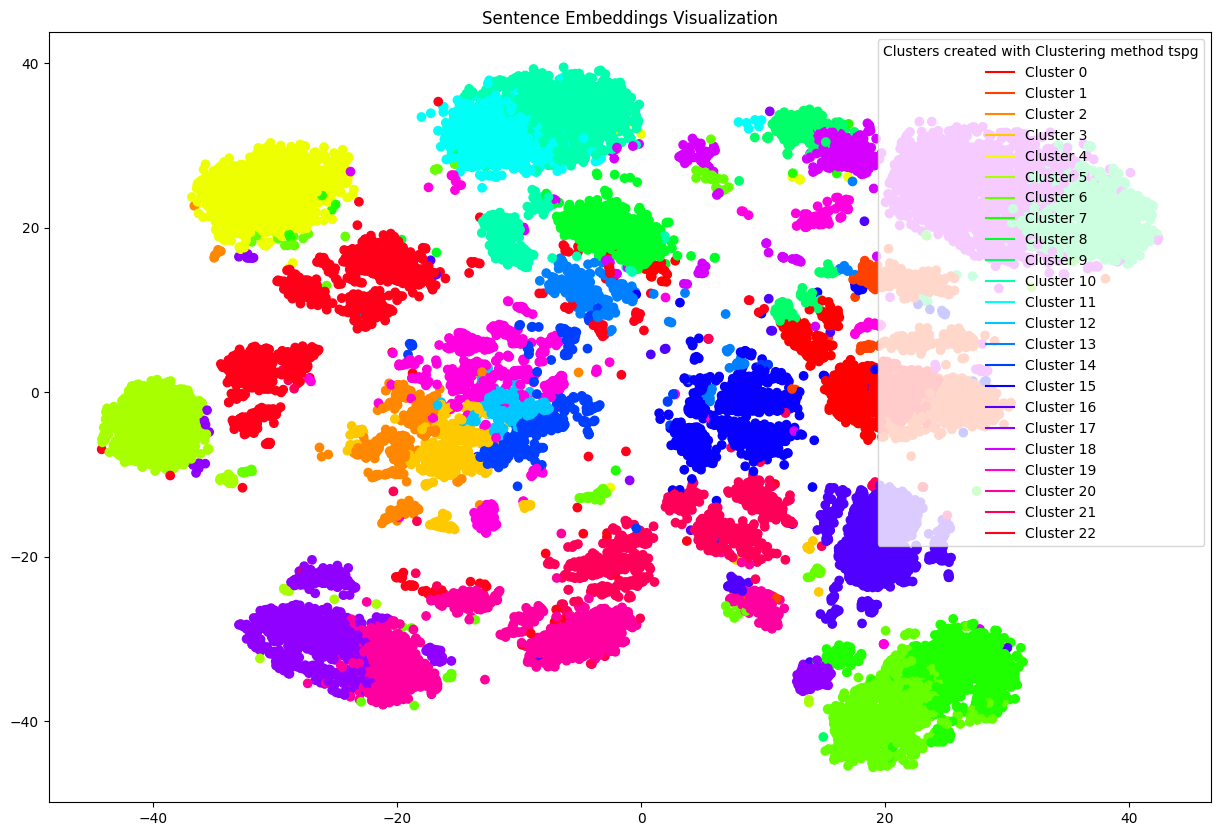

In [24]:
# Clusters visualization
def plot_sentence_embeddings(embeddings, cluster_labels=None, target_labels=None, clustering_method=None):
    plt.figure(figsize=(15, 10))
    tsne = TSNE(n_components=2, random_state= 73, perplexity=300, learning_rate=200, max_iter=1000)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))
    cmap = plt.colormaps['hsv']


    n_clusters = len(set(cluster_labels))
    colors = cmap(np.linspace(0, 1, n_clusters))
    handles = [plt.Line2D([], [], color=color) for color in colors]
    labels = [f"Cluster {i}" for i in range(n_clusters)]
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors[cluster_labels])

    plt.legend(handles=handles, labels=labels, title=f"Clusters created with {clustering_method}", loc = "upper right")
    plt.title(f"Sentence Embeddings Visualization")
plot_sentence_embeddings(embeddings, cluster_labels=labels, clustering_method=f"Clustering method {clustering_method}")

In [25]:
class SubgroupCreator:
    def __init__(self, X_df, targets_df, target_value):
        self.X_df = X_df
        self.targets_df = targets_df
        self.target_value = target_value
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}
        self.WRAcc_dict = {}
        self.Quality_dict = {}
        self.subgroups = {}
        self.total_coverage = 0

    def evaluate_rule(self, rule_str, covered_indices_set):
        parts = rule_str.split(" AND ")
        mask = pd.Series(True, index=self.X_df.index)

        description = []

        for part in parts:
            feature, operator, value = part.rsplit(maxsplit=2)
            value = float(value)

            if ">" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} = '{category_value}'")
                mask &= self.X_df[feature] > 0.5

            elif "<=" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} ≠ '{category_value}'")
                mask &= self.X_df[feature] <= 0.5

        covered_indices = set(self.X_df[mask].index) - covered_indices_set
        covered_indices_set.update(covered_indices)
        covered_targets = self.targets_df.loc[list(covered_indices)]

        tp = (covered_targets == self.target_value).sum().item()
        fp = (covered_targets != self.target_value).sum().item()
        TP = (self.targets_df == self.target_value).sum().item()
        FP = (self.targets_df != self.target_value).sum().item()

        WRAcc = ((tp + fp) / (TP + FP)) * ((tp / (tp + fp)) - (TP / (TP + FP)))

        return tp, fp, TP, FP, WRAcc, covered_indices, description
    def evaluate_all_clusters(self, subgroups):
        with open("results_SDUEBA.txt", "w") as f:
            for cluster, rules_list in subgroups.rules_dict.items():
                if cluster not in subgroups.unextractable_clusters:
                    covered_indices_set = set()

                    for idx, rule_str in enumerate(rules_list):
                        letter_index = string.ascii_lowercase[idx]
                        subgroup_label = f"{cluster}.{letter_index}"

                        tp, fp, TP, FP, WRAcc, covered_indices, description = self.evaluate_rule(rule_str, covered_indices_set)

                        self.tp_dict[subgroup_label] = tp
                        self.fp_dict[subgroup_label] = fp
                        self.TP_dict[subgroup_label] = TP
                        self.FP_dict[subgroup_label] = FP
                        self.WRAcc_dict[subgroup_label] = WRAcc
                        self.subgroups[subgroup_label] = covered_indices
                        self.total_coverage += tp + fp

                        description_str = ", ".join(str(item) for item in description)
                        self.Quality_dict[subgroup_label] = Quality_metric(
                            tp=tp,
                            fp=fp,
                            TP=TP,
                            FP=FP,
                            description_length=len(description),
                            description_length_limit=description_length_limit,
                            difference_limit=difference_limit,
                            subgroup_size_limit=subgroup_size_limit,
                        )

                        f.write(
                            f"Description: [{description_str}], Target: class = '{self.target_value}' ; "
                            f"QuMe = {float(self.Quality_dict[subgroup_label]) if self.Quality_dict[subgroup_label] is not None else 0:.8f} ; "
                            f"WRAcc = {float(WRAcc) if WRAcc is not None else 0:.8f} ; "
                            f"tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                        )
            f.write(f"Total coverage: {self.total_coverage / len(self.targets_df)}\n")


evaluator = SubgroupCreator(tree_trainer.X_df, target_df, target_value='Yes')
evaluator.evaluate_all_clusters(clusters)

In [26]:
%%time
from subgroups.algorithms import BSD
from subgroups.quality_measures import WRAcc
from subgroups.quality_measures import WRAccOptimisticEstimate1

dataset = df_sample_frac = pd.concat([features_raw, target_df], axis=1).astype(str)
target = ('readmit_binary', 'Yes')
print(len(dataset))

bsd_model = BSD(min_support=0, quality_measure=WRAcc(), optimistic_estimate = WRAccOptimisticEstimate1(), num_subgroups=50, max_depth=2, write_results_in_file = True, file_path = "./results_BSD.txt" )
bsd_model.fit(dataset, target)


20353
CPU times: user 45.4 s, sys: 133 ms, total: 45.5 s
Wall time: 46 s


In [27]:
def parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit):
    output_file = "results_BSD_.txt"

    with open(file_path, 'r') as file, open(output_file, 'w') as output:
        for line in file:
            match = re.search(r"(Description: \[.*?\]), Target: (.*?) ; Quality Measure WRAcc = ([\d.-]+) ; tp = (\d+) ; fp = (\d+) ; TP = (\d+) ; FP = (\d+)", line)

            if match:
                description = match.group(1)
                target = match.group(2)
                WRAcc = float(match.group(3))
                tp = int(match.group(4))
                fp = int(match.group(5))
                TP = int(match.group(6))
                FP = int(match.group(7))

                description_text = description[13:-1]
                description_length = description_text.count(',') + 1 if description_text else 1

                quality_score = Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit)

                output_line = f"{description}, Target: {target} ; QuMe = {quality_score:.8f} ; WRAcc = {WRAcc:.8f} ; tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                output.write(output_line)

file_path = "results_BSD.txt"
parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit)

In [28]:
#TODO Overlap ratio
def compute_coverage(filename, quality_measure, k, dataset_size, print_subgroups=False):
    with open(filename, 'r') as file:
        lines = file.readlines()

    subgroups = []
    instance_coverage = {}

    for line in lines:
        match = re.search(rf"{quality_measure}\s*=\s*([-+]?\d*\.?\d+)\s*;.*tp\s*=\s*(\d+)\s*;\s*fp\s*=\s*(\d+)", line)
        if match:
            quality = float(match.group(1))
            tp = int(match.group(2))
            fp = int(match.group(3))

            desc_match = re.search(r"Description: \[(.*?)\]", line)
            if desc_match:
                description = desc_match.group(1).split(", ")
            else:
                description = []

            mask = pd.Series(True, index=dataset.index)
            for condition in description:
                try:
                    feature, value = condition.split(" = ")
                    value = value.strip("'")

                    if feature not in dataset.columns:
                        continue

                    mask &= dataset[feature] == value
                except ValueError:
                    continue

            covered_instances = set(dataset[mask].index)

            for instance in covered_instances:
                instance_coverage[instance] = instance_coverage.get(instance, 0) + 1

            subgroups.append((quality, covered_instances, description, line.strip()))

    subgroups.sort(reverse=True, key=lambda x: x[0])
    top_k_subgroups = subgroups[:k]

    covered_instances = set()
    filtered_instance_coverage = {}

    for _, instance_ids, _, _ in top_k_subgroups:
        covered_instances.update(instance_ids)
        for instance in instance_ids:
            filtered_instance_coverage[instance] = filtered_instance_coverage.get(instance, 0) + 1

    coverage = len(covered_instances) / len(dataset) if len(dataset) else 0
    overlapping_instances = sum(1 for count in filtered_instance_coverage.values() if count > 1)
    overlap_ratio = overlapping_instances / len(covered_instances) if covered_instances else 0

    if print_subgroups:
        print("Top-k subgroups:")
        for _, _, _, subgroup in top_k_subgroups:
            print(subgroup)

    return coverage, overlap_ratio

print("SDUEBA model:")
coverage_SDUEBA, overlap_SDUEBA = compute_coverage('results_SDUEBA.txt', 'QuMe', 20, len(target_df), True)
print(f"Coverage: {coverage_SDUEBA}, Overlap Ratio: {overlap_SDUEBA}")

print("BSD model:")
coverage_BSD, overlap_BSD = compute_coverage('results_BSD_.txt', 'QuMe', 20, len(target_df), True)
print(f"Coverage: {coverage_BSD}, Overlap Ratio: {overlap_BSD}")

SDUEBA model:
Top-k subgroups:
Description: [had_emergency ≠ 'False', change = 'Ch'], Target: class = 'Yes' ; QuMe = 0.09807795 ; WRAcc = 0.01117972 ; tp = 763 ; fp = 397 ; TP = 9395 ; FP = 10958
Description: [had_emergency ≠ 'False', change = 'Ch'], Target: class = 'Yes' ; QuMe = 0.09807795 ; WRAcc = 0.01117972 ; tp = 763 ; fp = 397 ; TP = 9395 ; FP = 10958
Description: [change = 'Ch', admission_source_id = '6'], Target: class = 'Yes' ; QuMe = 0.08986176 ; WRAcc = -0.00131572 ; tp = 42 ; fp = 107 ; TP = 9395 ; FP = 10958
Description: [had_inpatient_days ≠ 'False', change = 'Ch'], Target: class = 'Yes' ; QuMe = 0.08853017 ; WRAcc = 0.02889094 ; tp = 2121 ; fp = 1200 ; TP = 9395 ; FP = 10958
Description: [had_emergency ≠ 'False', change ≠ 'Ch'], Target: class = 'Yes' ; QuMe = 0.08772777 ; WRAcc = 0.00902579 ; tp = 667 ; fp = 380 ; TP = 9395 ; FP = 10958
Description: [had_emergency ≠ 'False', change ≠ 'Ch'], Target: class = 'Yes' ; QuMe = 0.08772777 ; WRAcc = 0.00902579 ; tp = 667 ; fp =